<a href="https://colab.research.google.com/github/Sejup2032/Insider-Sentiment-Analysis-for-Stock-Movements/blob/main/Sentiment_Analysis_for_Stock_Movements.ipynb" target="_parent"></a>

In [113]:
pip install yfinance pandas matplotlib seaborn nltk textblob

**Import Libraries**

In [114]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

###Download stopwords for text cleaning
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Extract Historical Stock Prices**

In [115]:
##Define stock ticker and date range
stock_ticker = 'GOOG'
start_date = '2017-12-17'
end_date = '2020-07-18'

#Download stock price data
stock_Data = yf.download(stock_ticker, start = start_date, end = end_date)

#Calculate daily % change
stock_Data['Price_Change'] = stock_Data['Close'].pct_change()

#reset index for merging
stock_Data = stock_Data.reset_index()
print(stock_Data.head())

/tmp/ipython-input-2167183532.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_Data = yf.download(stock_ticker, start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed

Price        Date      Close       High  ...       Open    Volume Price_Change
Ticker                  GOOG       GOOG  ...       GOOG      GOOG             
0      2017-12-18  53.490944  53.557986  ...  52.941705  31092000          NaN
1      2017-12-19  53.170139  53.476045  ...  53.394601  26774000    -0.005997
2      2017-12-20  52.885593  53.304226  ...  53.224772  25372000    -0.005352
3      2017-12-21  52.820038  53.103101  ...  52.885591  19914000    -0.001240
4      2017-12-22  52.645733  52.848345  ...  52.694896  15102000    -0.003300

[5 rows x 7 columns]


**Install kaggle API and Upload kaggle API key**

In [116]:
!pip install kaggle

In [117]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [118]:
!kaggle datasets download -d notlucasp/financial-news-headlines
!unzip financial-news-headlines.zip -d financial_news

Dataset URL: https://www.kaggle.com/datasets/notlucasp/financial-news-headlines
License(s): CC0-1.0
financial-news-headlines.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  financial-news-headlines.zip
replace financial_news/cnbc_headlines.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Load and Combine all three news sources**

In [119]:
!ls financial_news


cnbc_headlines.csv  guardian_headlines.csv  reuters_headlines.csv


In [120]:
#load news headlines dataset as CSV Files
import pandas as pd

# Load each source
cnbc_df = pd.read_csv('financial_news/cnbc_headlines.csv')
guardian_df = pd.read_csv('financial_news/guardian_headlines.csv')
reuters_df = pd.read_csv('financial_news/reuters_headlines.csv')

# Add a column to track source
cnbc_df['source'] = 'CNBC'
guardian_df['source'] = 'Guardian'
reuters_df['source'] = 'Reuters'

# Combine all three datasets
news_df = pd.concat([cnbc_df, guardian_df, reuters_df], ignore_index=True)

# Preview the combined dataset
news_df.head()


,Headlines,Time,Description,source
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying...",CNBC
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin...",CNBC
2,NaN,NaN,NaN,CNBC
3,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co...",CNBC
4,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be...",CNBC


**Preprocess Headlines**

In [121]:
import nltk

# Download required NLTK packages
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Clean Text for sentiment Analysis**

In [122]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

#function to clean headlines
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', str(text))
    text = text.lower()
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

#Apply cleaning
news_df['cleaned_headline'] = news_df['Headlines'].apply(clean_text)

#preview of cleaned headlines
news_df[['Headlines', 'cleaned_headline', 'source']].head()

,Headlines,cleaned_headline,source
0,Jim Cramer: A better way to invest in the Covi...,jim cramer better way invest covid vaccine gol...,CNBC
1,Cramer's lightning round: I would own Teradyne,cramers lightning round would teradyne,CNBC
2,NaN,nan,CNBC
3,"Cramer's week ahead: Big week for earnings, ev...",cramers week ahead big week earnings even bigg...,CNBC
4,IQ Capital CEO Keith Bliss says tech and healt...,iq capital ceo keith bliss says tech healthcar...,CNBC


In [123]:
# Check columns for each source
print("CNBC columns:", cnbc_df.columns)
print("Guardian columns:", guardian_df.columns)
print("Reuters columns:", reuters_df.columns)


CNBC columns: Index(['Headlines', 'Time', 'Description', 'source'], dtype='object')
Guardian columns: Index(['Time', 'Headlines', 'source'], dtype='object')
Reuters columns: Index(['Headlines', 'Time', 'Description', 'source'], dtype='object')


In [124]:
import yfinance as yf

stock_Data = yf.download(stock_ticker, start = start_date, end = end_date)
stock_Data.reset_index(inplace=True)

# Convert news 'Time' column to datetime (correct column name)
news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')  # coerce invalid dates to NaT
news_df = news_df.dropna(subset=['Time'])  # remove rows with invalid dates

# Convert stock dataframe 'Date' column to datetime
stock_Data['Date'] = pd.to_datetime(stock_Data['Date'])

/tmp/ipython-input-3241609001.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_Data = yf.download(stock_ticker, start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3241609001.py:7: FutureWarning: Parsed string " 7:51  PM ET Fri, 17 July 2020" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')  # coerce invalid dates to NaT
/tmp/ipython-input-3241609001.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')  # coerce invalid dates

In [125]:
print(stock_Data.head())
print(stock_Data.index)


Price        Date      Close       High        Low       Open    Volume
Ticker                  GOOG       GOOG       GOOG       GOOG      GOOG
0      2017-12-18  53.490944  53.557986  52.739089  52.941705  31092000
1      2017-12-19  53.170139  53.476045  52.816064  53.394601  26774000
2      2017-12-20  52.885593  53.304226  52.715258  53.224772  25372000
3      2017-12-21  52.820038  53.103101  52.728861  52.885591  19914000
4      2017-12-22  52.645733  52.848345  52.611964  52.694896  15102000
RangeIndex(start=0, stop=649, step=1)


In [126]:
# Flatten MultiIndex columns if present
stock_Data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_Data.columns]

# Optional: rename columns for simplicity
stock_Data.rename(columns={'Date_': 'Date',
                           'Close_GOOG': 'Close',
                           'Open_GOOG': 'Open',
                           'High_GOOG': 'High',
                           'Low_GOOG': 'Low',
                           'Volume_GOOG': 'Volume'}, inplace=True)

# Preview
stock_Data.head()


,Date,Close,High,Low,Open,Volume
0,2017-12-18,53.490944,53.557986,52.739089,52.941705,31092000
1,2017-12-19,53.170139,53.476045,52.816064,53.394601,26774000
2,2017-12-20,52.885593,53.304226,52.715258,53.224772,25372000
3,2017-12-21,52.820038,53.103101,52.728861,52.885591,19914000
4,2017-12-22,52.645733,52.848345,52.611964,52.694896,15102000


In [127]:
news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')
news_df = news_df.dropna(subset=['Time'])

stock_Data['Date'] = pd.to_datetime(stock_Data['Date'])


**Merge News with Stock Data**

In [128]:
news_df['Date'] = news_df['Time'].dt.date
stock_Data['Date_only'] = stock_Data['Date'].dt.date
stock_Data['next_day_change'] = stock_Data['Close'].pct_change().shift(-1)

merged_df = pd.merge(news_df, stock_Data[['Date_only', 'Close', 'next_day_change']], left_on='Date', right_on='Date_only', how='left')

# Remove rows where stock data is missing
merged_df = merged_df.dropna(subset=['Close', 'next_day_change'])


print(merged_df)

                                               Headlines  ... next_day_change
4      Wall Street delivered the 'kind of pullback I'...  ...       -0.001614
5      Cramer's lightning round: I would just stay lo...  ...       -0.001614
6      Acorns CEO: Parents can turn $5 into five figu...  ...       -0.001614
7      Dividend cuts may mean rethinking your retirem...  ...       -0.001614
8      StockX has authenticated 1 million Jordan snea...  ...        0.002881
...                                                  ...  ...             ...
53325  Malaysia says never hired British data firm at...  ...       -0.006222
53326  Prosecutors search Volkswagen headquarters in ...  ...       -0.006222
53327   McDonald's sets greenhouse gas reduction targets  ...       -0.006222
53328  Pratt & Whitney to deliver spare A320neo engin...  ...       -0.006222
53329  UK will always consider ways to improve data l...  ...       -0.006222

[47193 rows x 9 columns]


In [129]:
# Ensure datetime
news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')
news_df = news_df.dropna(subset=['Time'])
news_df = news_df.sort_values('Time')

stock_Data['Date'] = pd.to_datetime(stock_Data['Date'])
stock_Data = stock_Data.sort_values('Date')

# Merge using 'merge_asof' to get the **last stock price on or before the news**
merged_df = pd.merge_asof(
    news_df,
    stock_Data[['Date', 'Close', 'next_day_change']],
    left_on='Time',
    right_on='Date',
    direction='backward'  # closest previous date
)

# Drop rows where Close is still NaN (if news is before first stock date)
merged_df = merged_df.dropna(subset=['Close', 'next_day_change'])
print(merged_df)

                                               Headlines  ... next_day_change
20     Universal basic income is no panacea for us – ...  ...       -0.005997
21     Brexit will usher in a dark chapter for new Br...  ...       -0.005997
22     Adani scraps $2bn deal to outsource Carmichael...  ...       -0.005997
23     Ryanair pilots suspend one-day strike in week ...  ...       -0.005997
24               Curbs on capitalism in the 21st century  ...       -0.005997
...                                                  ...  ...             ...
53229  EU's Vestager says court rulings on Apple taxe...  ...       -0.001614
53230  Dividend cuts may mean rethinking your retirem...  ...       -0.001614
53231  Cramer's lightning round: I would just stay lo...  ...       -0.001614
53232  Wall Street delivered the 'kind of pullback I'...  ...       -0.001614
53233  Acorns CEO: Parents can turn $5 into five figu...  ...       -0.001614

[53214 rows x 9 columns]


In [130]:
print("News date range:", news_df['Time'].min(), "to", news_df['Time'].max())
print("Stock date range:", stock_Data['Date'].min(), "to", stock_Data['Date'].max())


News date range: 2017-12-17 00:00:00 to 2020-07-18 00:00:00
Stock date range: 2017-12-18 00:00:00 to 2020-07-17 00:00:00


**Sentiment Analysis**

In [131]:
from textblob import TextBlob
#calculate sentiment analysis
merged_df['sentiment'] = merged_df['cleaned_headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

#categorize sentiment
def categorize_sentiment(sentiment):
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

merged_df['sentiment_category'] = merged_df['sentiment'].apply(categorize_sentiment)

#preview results
merged_df[['Time','cleaned_headline', 'sentiment', 'sentiment_category','Close']].head()

,Time,cleaned_headline,sentiment,sentiment_category,Close
20,2017-12-18,universal basic income panacea us labour shoul...,0.000000,Neutral,53.490944
21,2017-12-18,brexit usher dark chapter new british authors ...,-0.004545,Negative,53.490944
22,2017-12-18,adani scraps bn deal outsource carmichael coal...,0.000000,Neutral,53.490944
23,2017-12-18,ryanair pilots suspend oneday strike week chri...,0.000000,Neutral,53.490944
24,2017-12-18,curbs capitalism st century,0.000000,Neutral,53.490944


**Visualize sentiment vs stock proce movement**

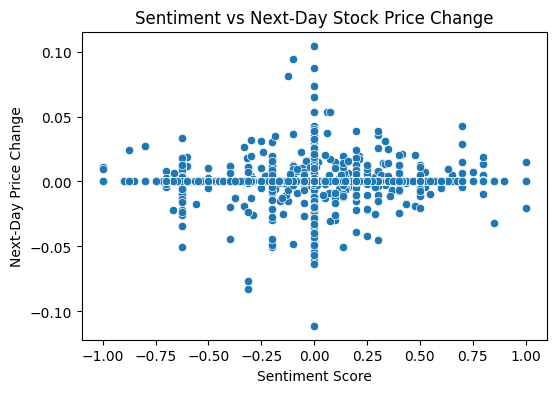

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns


#calculate next-day price change
merged_df['next_day_change'] = merged_df['Close'].pct_change().shift(-1)


#Scatter plot

plt.figure(figsize=(6,4))
sns.scatterplot(x='sentiment', y='next_day_change', data=merged_df)
plt.title('Sentiment vs Next-Day Stock Price Change')
plt.xlabel('Sentiment Score')
plt.ylabel('Next-Day Price Change')
plt.show()

**Sentiment distribution**

/tmp/ipython-input-2506245555.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=merged_df, palette={'Positive':'green','Negative':'red','Neutral':'gray'})


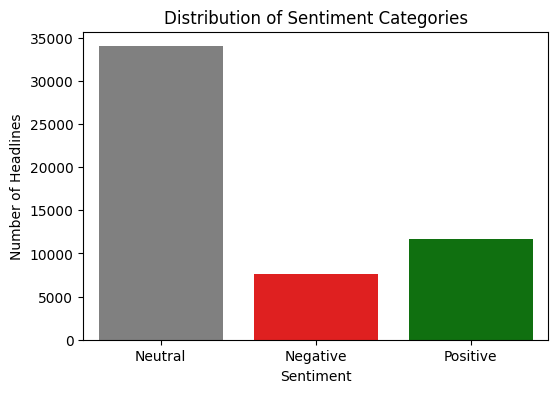

In [133]:
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_category', data=merged_df, palette={'Positive':'green','Negative':'red','Neutral':'gray'})
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()


**Average next-day stock change by sentiment**

/tmp/ipython-input-3021358408.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment_category', y='next_day_change', data=avg_change,


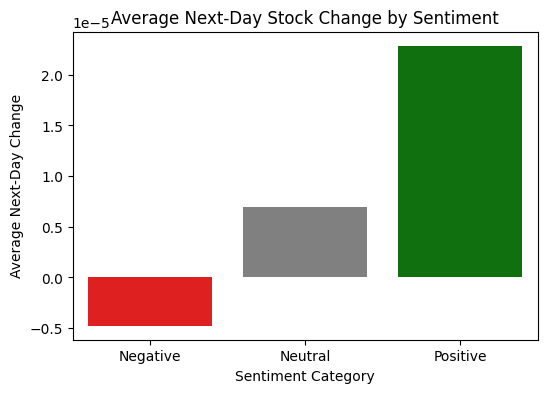

In [134]:
avg_change = merged_df.groupby('sentiment_category')['next_day_change'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='sentiment_category', y='next_day_change', data=avg_change,
            palette={'Positive':'green','Negative':'red','Neutral':'gray'})
plt.title('Average Next-Day Stock Change by Sentiment')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Next-Day Change')
plt.show()


**Time series: Sentiment over time**

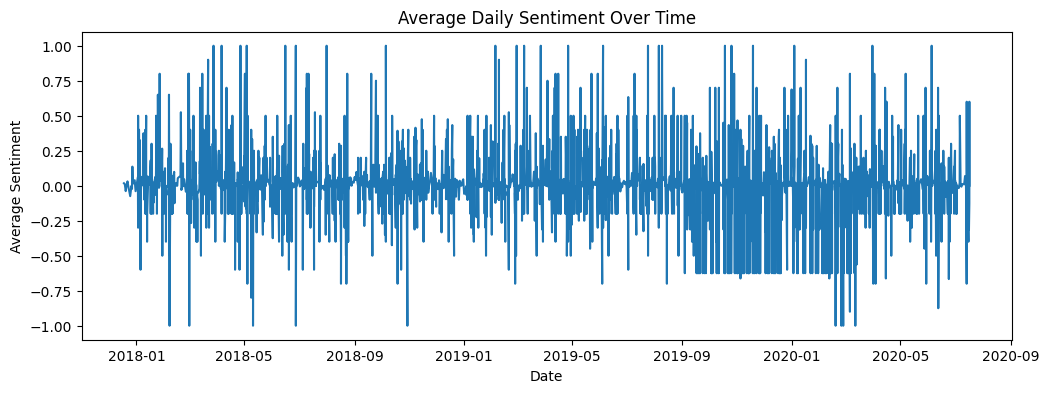

In [135]:
daily_sentiment = merged_df.groupby('Time')['sentiment'].mean().reset_index()

plt.figure(figsize=(12,4))
sns.lineplot(x='Time', y='sentiment', data=daily_sentiment)
plt.title('Average Daily Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()


**Stock price vs aggregated sentiment**

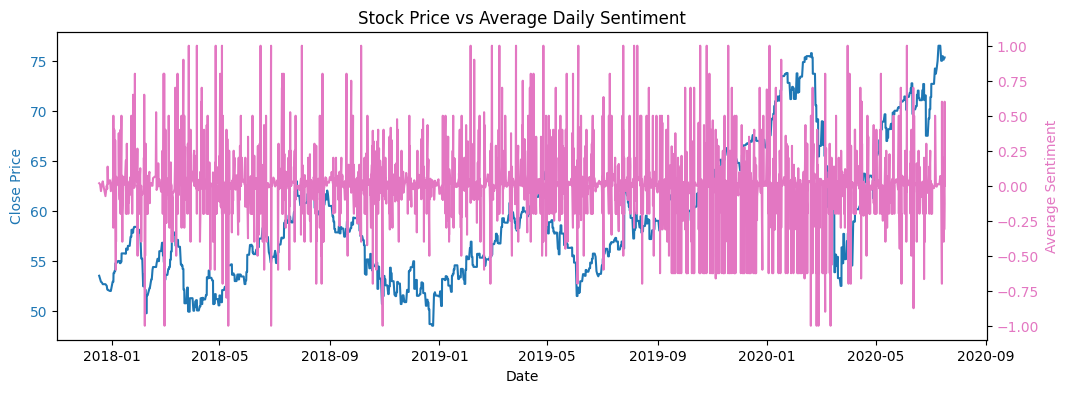

In [136]:
daily = merged_df.groupby('Time').agg({'sentiment':'mean','Close':'mean'}).reset_index()

fig, ax1 = plt.subplots(figsize=(12,4))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(daily['Time'], daily['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:pink'
ax2.set_ylabel('Average Sentiment', color=color)
ax2.plot(daily['Time'], daily['sentiment'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Stock Price vs Average Daily Sentiment')
plt.show()


**Heatmap: Sentiment by weekday**

/tmp/ipython-input-2900044229.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday', y='sentiment', data=weekday_sentiment, palette='coolwarm')


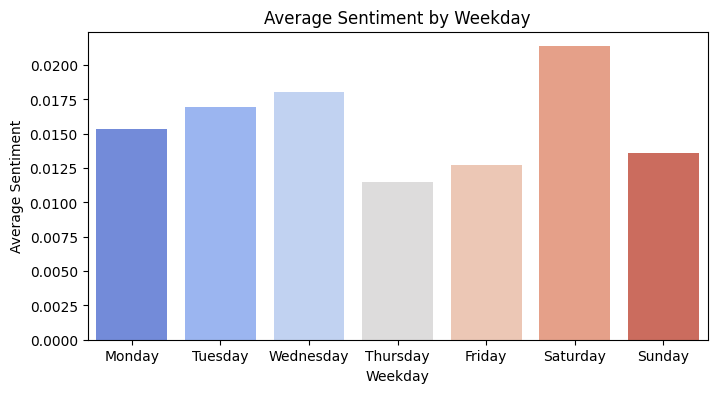

In [137]:
merged_df['weekday'] = merged_df['Time'].dt.day_name()
weekday_sentiment = merged_df.groupby('weekday')['sentiment'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x='weekday', y='sentiment', data=weekday_sentiment, palette='coolwarm')
plt.title('Average Sentiment by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Sentiment')
plt.show()


**Density plot / KDE**

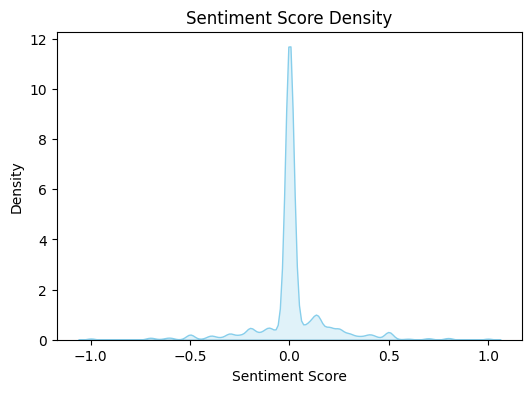

In [140]:
plt.figure(figsize=(6,4))
sns.kdeplot(merged_df['sentiment'], fill=True, color='skyblue')
plt.title('Sentiment Score Density')
plt.xlabel('Sentiment Score')
plt.show()
